# LLM - Hugging Face - DistilBERT

Este notebook implementa un modelo de DistilBERT utilizando la biblioteca Hugging Face para realizar tareas de clasificación de texto. El objetivo del experimento es evaluar el rendimiento del modelo en términos de precisión y eficiencia, aplicando técnicas de Transfer Learning y Fine-Tuning.

## Libraries

In [29]:
import transformers
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Dataset

In [2]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [3]:
# Convert the pandas DataFrame into a Dataset
df_dict_train = Dataset.from_pandas(df_train)
df_dict_train = df_dict_train.class_encode_column("emotion")

df_dict_val = Dataset.from_pandas(df_val)
df_dict_val = df_dict_val.class_encode_column("emotion")

df_dict_test = Dataset.from_pandas(df_test)
df_dict_test = df_dict_test.class_encode_column("emotion")


# Crear el DatasetDict con train, validation y test
dataset_dict = DatasetDict(
    {
        "train": df_dict_train,
        "validation": df_dict_val,
        "test": df_dict_test,
    }
)

# Remover la columna '__index_level_0__' que no es necesaria
# dataset_dict = dataset_dict.remove_columns(["__index_level_0__"])

# Verificar el resultado
dataset_dict

Casting to class labels:   0%|          | 0/6027 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/753 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'emotion'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'emotion'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'emotion'],
        num_rows: 754
    })
})

## 1. Transfer Learning using Zero-shot classification

In [27]:
# Crear la lista para almacenar los resultados
results = []

# Zero-shot classification - permite indicar las etiquetas candidatas
classifier = pipeline(
    "zero-shot-classification", device="cuda", model="distilbert-base-uncased"
)

candidate_labels = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]

for text in df_test["text"]:
    result = classifier(text, candidate_labels, clean_up_tokenization_spaces=True)

    # Almacenar el texto, la etiqueta predicha, y las puntuaciones del primer resultado
    results.append(
        {
            "Text": text,
            "Predicted Label": result["labels"][0],  # Etiqueta con la mayor puntuación
            "Scores": result["scores"],  # Puntajes de todas las etiquetas candidatas
            "All Labels": result[
                "labels"
            ],  # Todas las etiquetas ordenadas por probabilidad
        }
    )

results[0]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'Text': "when a friend carelessly broke and object in my parent's house and did not apologize, or pay, or anything",
 'Predicted Label': 'anger',
 'Scores': [0.14333991706371307,
  0.14305460453033447,
  0.14297692477703094,
  0.14295350015163422,
  0.14289438724517822,
  0.14242346584796906,
  0.14235720038414001],
 'All Labels': ['anger',
  'fear',
  'disgust',
  'joy',
  'guilt',
  'shame',
  'sadness']}

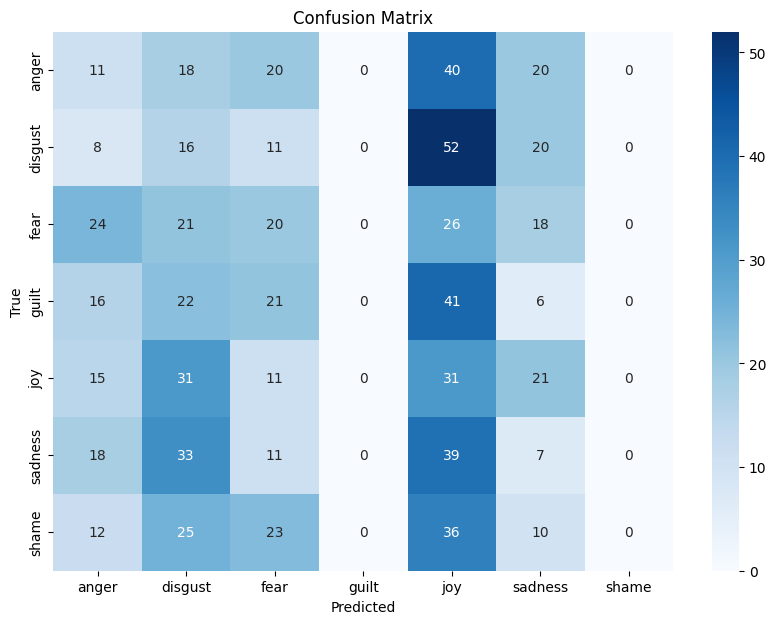

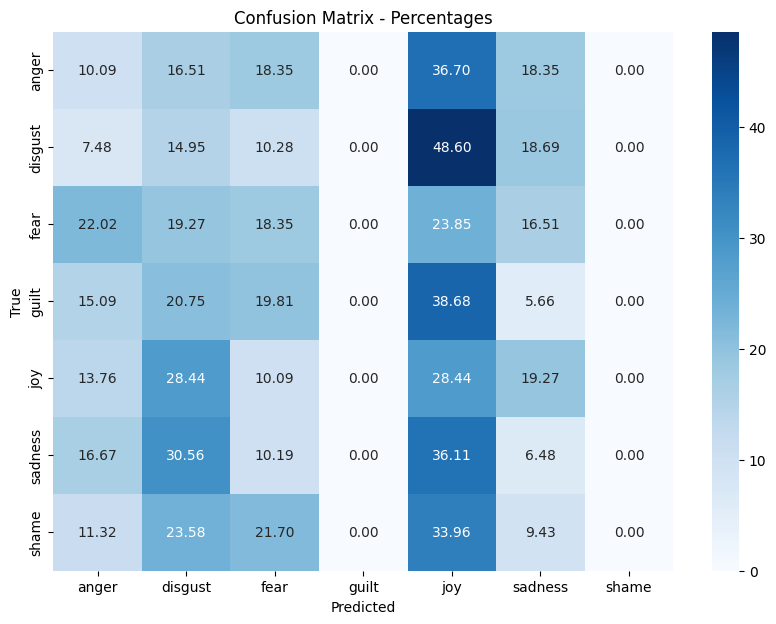

{'anger': {'precision': 0.10576923076923077, 'recall': 0.10091743119266056, 'f1-score': 0.10328638497652583, 'support': 109.0}, 'disgust': {'precision': 0.0963855421686747, 'recall': 0.14953271028037382, 'f1-score': 0.11721611721611722, 'support': 107.0}, 'fear': {'precision': 0.17094017094017094, 'recall': 0.1834862385321101, 'f1-score': 0.17699115044247787, 'support': 109.0}, 'guilt': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'joy': {'precision': 0.1169811320754717, 'recall': 0.28440366972477066, 'f1-score': 0.1657754010695187, 'support': 109.0}, 'sadness': {'precision': 0.06862745098039216, 'recall': 0.06481481481481481, 'f1-score': 0.06666666666666667, 'support': 108.0}, 'shame': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'accuracy': 0.11273209549071618, 'macro avg': {'precision': 0.07981478956199146, 'recall': 0.11187926636353283, 'f1-score': 0.0899908171959009, 'support': 754.0}, 'weighted avg': {'precision': 0.08042080358154

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,distilbert-base-uncased,Zero-shot Classification,0.112732,0.079815,0.111879,0.089991


In [32]:
# Suponemos que df_test ya tiene una columna "True Label" con las etiquetas reales
true_labels = df_test["emotion"]

# Crear un DataFrame con los resultados (ya lo tienes en la lista `results`)
results_df = pd.DataFrame(results)

# Extraer las etiquetas predichas
predicted_labels = results_df["Predicted Label"]

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=candidate_labels)

# Mostrar la matriz de confusión con seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Crear la matriz de confusión en porcentajes
conf_matrix_percentage = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
)

# Mostrar la matriz de confusión con valores en porcentajes
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Percentages")
plt.show()


# Calcular el informe de métricas (precisión, recall, F1-score) como un diccionario
report = classification_report(
    true_labels, predicted_labels, target_names=candidate_labels, output_dict=True
)
print(report)

# Calcular accuracy general
accuracy = accuracy_score(true_labels, predicted_labels)

# Extraer las métricas clave del reporte
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Crear una lista de resultados con las métricas clave
results_summary = []

# Almacenar las métricas en la lista de resultados
results_summary.append(
    {
        "Model": "distilbert-base-uncased",
        "Method": "Zero-shot Classification",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convertir los resultados a un DataFrame
results_summary_df = pd.DataFrame(results_summary)

# Mostrar el DataFrame de resultados con las métricas
results_summary_df


## 2. Fine-Tuning

### Tokenize Text

In [58]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)


def preprocess_function(examples, func_tokenizer):
    return func_tokenizer(examples["text"], truncation=True)


tokenized_dataset = dataset_dict.map(
    preprocess_function,
    batched=True,
    # num_proc=20,
    fn_kwargs={"func_tokenizer": tokenizer},
)

tokenized_dataset = tokenized_dataset.rename_column("emotion", "label")
print(tokenized_dataset)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 754
    })
})


### Formating Labels

In [59]:
id2label = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "guilt",
    4: "joy",
    5: "sadness",
    6: "shame",
}
label2id = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "guilt": 3,
    "joy": 4,
    "sadness": 5,
    "shame": 6,
}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define model
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=7, id2label=id2label, label2id=label2id
    ).to(device)

## Define Model To FineTuning

In [60]:
training_args = transformers.TrainingArguments(
    output_dir="..data/results/distilbert",
    learning_rate=3e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=20,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
)

### Define metrics

In [61]:
recall = evaluate.load("recall")
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    pre = precision.compute(
        predictions=predictions, references=labels, average="weighted"
    )["precision"]
    rec = recall.compute(
        predictions=predictions, references=labels, average="weighted"
    )["recall"]
    f1_score = f1.compute(
        predictions=predictions, references=labels, average="weighted"
    )["f1"]
    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": pre, "recall": rec, "f1": f1_score, "accuracy": acc}


## Run Finetuning

In [62]:
trainer = transformers.Trainer(
    model=model_init(),
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.118785,0.633138,0.620186,0.617235,0.620186
2,No log,0.929500,0.678878,0.679947,0.676826,0.679947
3,No log,0.969378,0.693695,0.673307,0.674685,0.673307
4,No log,1.006097,0.661657,0.652058,0.654748,0.652058
5,No log,1.076226,0.678618,0.674635,0.674533,0.674635
6,0.771800,1.150565,0.675899,0.673307,0.674053,0.673307
7,0.771800,1.260139,0.694102,0.679947,0.683318,0.679947
8,0.771800,1.326654,0.688987,0.683931,0.684194,0.683931
9,0.771800,1.472971,0.689737,0.671979,0.676001,0.671979
10,0.771800,1.516474,0.682573,0.682603,0.682294,0.682603


TrainOutput(global_step=1900, training_loss=0.2384845821481002, metrics={'train_runtime': 669.4938, 'train_samples_per_second': 180.046, 'train_steps_per_second': 2.838, 'total_flos': 1820208203799654.0, 'train_loss': 0.2384845821481002, 'epoch': 20.0})

In [63]:
trainer.evaluate()

{'eval_loss': 0.929500162601471,
 'eval_precision': 0.6788782357032319,
 'eval_recall': 0.6799468791500664,
 'eval_f1': 0.6768264065362788,
 'eval_accuracy': 0.6799468791500664,
 'eval_runtime': 2.5539,
 'eval_samples_per_second': 294.839,
 'eval_steps_per_second': 4.699,
 'epoch': 20.0}

In [64]:
trainer.save_model("models/distilbert-base-uncased-finetuned")

## Use finetunned model to predict

In [33]:
# Crear la lista para almacenar los resultados
results = []

# Zero-shot classification - permite indicar las etiquetas candidatas
classifier = pipeline(
    "zero-shot-classification",
    device="cuda",
    model="models/distilbert-base-uncased-finetuned/",
)

candidate_labels = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]

for text in df_test["text"]:
    result = classifier(text, candidate_labels, clean_up_tokenization_spaces=True)

    # Almacenar el texto, la etiqueta predicha, y las puntuaciones del primer resultado
    results.append(
        {
            "Text": text,
            "Predicted Label": result["labels"][0],  # Etiqueta con la mayor puntuación
            "Scores": result["scores"],  # Puntajes de todas las etiquetas candidatas
            "All Labels": result[
                "labels"
            ],  # Todas las etiquetas ordenadas por probabilidad
        }
    )

results[0]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'Text': "when a friend carelessly broke and object in my parent's house and did not apologize, or pay, or anything",
 'Predicted Label': 'shame',
 'Scores': [0.6624699831008911,
  0.09849970787763596,
  0.07923567295074463,
  0.046086475253105164,
  0.04099774733185768,
  0.04047248512506485,
  0.03223791718482971],
 'All Labels': ['shame',
  'joy',
  'guilt',
  'anger',
  'sadness',
  'disgust',
  'fear']}

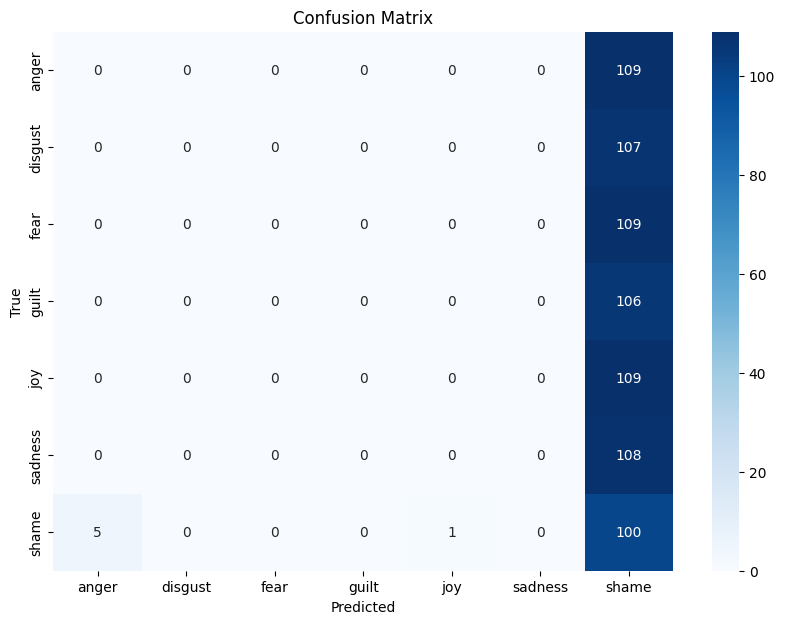

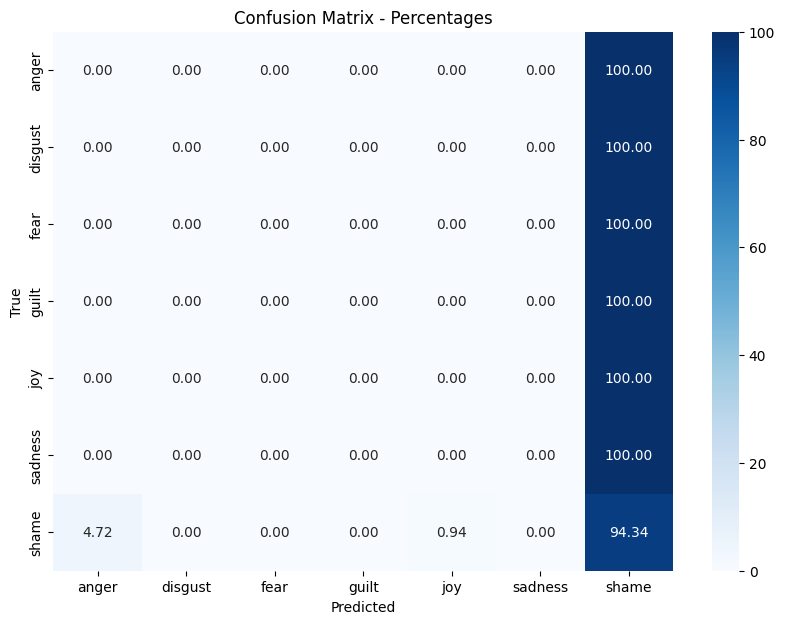

{'anger': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 109.0}, 'disgust': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 107.0}, 'fear': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 109.0}, 'guilt': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'joy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 109.0}, 'sadness': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 108.0}, 'shame': {'precision': 0.13368983957219252, 'recall': 0.9433962264150944, 'f1-score': 0.234192037470726, 'support': 106.0}, 'accuracy': 0.13262599469496023, 'macro avg': {'precision': 0.01909854851031322, 'recall': 0.1347708894878706, 'f1-score': 0.03345600535296086, 'support': 754.0}, 'weighted avg': {'precision': 0.018794592831103987, 'recall': 0.13262599469496023, 'f1-score': 0.0329235490343461, 'support': 754.0}}


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,distilbert-base-uncased_finetuned,Zero-shot Classification,0.132626,0.019099,0.134771,0.033456
0,distilbert-base-uncased,Zero-shot Classification,0.112732,0.079815,0.111879,0.089991


In [34]:
# Suponemos que df_test ya tiene una columna "True Label" con las etiquetas reales
true_labels = df_test["emotion"]

# Crear un DataFrame con los resultados (ya lo tienes en la lista `results`)
results_df = pd.DataFrame(results)

# Extraer las etiquetas predichas
predicted_labels = results_df["Predicted Label"]

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=candidate_labels)

# Mostrar la matriz de confusión con seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Crear la matriz de confusión en porcentajes
conf_matrix_percentage = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
)

# Mostrar la matriz de confusión con valores en porcentajes
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=candidate_labels,
    yticklabels=candidate_labels,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Percentages")
plt.show()


# Calcular el informe de métricas (precisión, recall, F1-score) como un diccionario
report = classification_report(
    true_labels, predicted_labels, target_names=candidate_labels, output_dict=True
)
print(report)

# Calcular accuracy general
accuracy = accuracy_score(true_labels, predicted_labels)

# Extraer las métricas clave del reporte
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Crear una lista de resultados con las métricas clave
results_summary = []

# Almacenar las métricas en la lista de resultados
results_summary.append(
    {
        "Model": "distilbert-base-uncased_finetuned",
        "Method": "Zero-shot Classification",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convertir los resultados a un DataFrame
results_summary_df_finetuned = pd.DataFrame(results_summary)

# Mostrar el DataFrame de resultados con las métricas
results_summary_df = pd.concat([results_summary_df_finetuned, results_summary_df])
results_summary_df

In [35]:
results_df

,Text,Predicted Label,Scores,All Labels
0,when a friend carelessly broke and object in m...,shame,"[0.6624699831008911, 0.09849970787763596, 0.07...","[shame, joy, guilt, anger, sadness, disgust, f..."
1,when i felt powerless to help the poor or when...,shame,"[0.7720120549201965, 0.07478225231170654, 0.04...","[shame, guilt, anger, joy, disgust, sadness, f..."
2,one of my best friends'fianct broke off the re...,shame,"[0.18149736523628235, 0.17345422506332397, 0.1...","[shame, fear, joy, anger, sadness, guilt, disg..."
3,i hadn't been at my parent's place for a long ...,shame,"[0.7883551716804504, 0.0716133564710617, 0.060...","[shame, guilt, anger, disgust, joy, fear, sadn..."
4,when i didn't notify someone that he was summo...,shame,"[0.7348353266716003, 0.08867065608501434, 0.05...","[shame, guilt, joy, anger, disgust, sadness, f..."
...,...,...,...,...
749,finding out that china is still backward in sc...,shame,"[0.7132905125617981, 0.1314682513475418, 0.053...","[shame, guilt, anger, disgust, joy, fear, sadn..."
750,they wanted me to pay for a ticket twice becau...,shame,"[0.7954415678977966, 0.06998804956674576, 0.03...","[shame, guilt, anger, disgust, joy, sadness, f..."
751,i had this feeling when my parents distroyed a...,shame,"[0.7375830411911011, 0.07453511655330658, 0.07...","[shame, guilt, joy, anger, disgust, sadness, f..."
752,i was on a concert-tour and therefor seperated...,shame,"[0.36748093366622925, 0.1436517983675003, 0.10...","[shame, disgust, anger, guilt, fear, joy, sadn..."
